# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Proje Kod Dosyası

* **Grup Adı:** DevTe213
* **Öğrenci:** Burak Şahin
* **Model Stratejisi:** Large Kernel (Receptive Field Variation)
* **Açıklama:** Bu notebook, standart 3x3 filtreler yerine daha geniş (7x7) filtreler kullanmanın, tümörün çevresel bağlamını (context) yakalama ve genel desenleri öğrenme üzerindeki etkisini analiz etmek amacıyla hazırlanmıştır.
* **Veri Seti:** Sartaj Bhuvaji (Kaggle) - Brain Tumor Classification (MRI)
  * 4 Sınıf: Glioma, Meningioma, Pituitary, No Tumor

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- ORTAK SEED AYARI (GRUP STANDARDI) ---
SEED = 213
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

Kullanılan Cihaz: cuda


In [2]:
# --- HİPER-PARAMETRELER ---
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 15

# --- VERİ YOLU ---
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-1\training"

# Pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
    
    # Train/Val/Test Ayrımı
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Veri Yüklendi. Toplam: {len(full_dataset)}")
    print(f"Sınıflar: {full_dataset.classes}")
    
except Exception as e:
    print(f"HATA: Veri yolu yanlış! {e}")

Veri Yüklendi. Toplam: 2870
Sınıflar: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [5]:
class LargeKernelModel(nn.Module):
    def __init__(self):
        super(LargeKernelModel, self).__init__()
        
        # --- BLOK 1 (BURAK ŞAHİN FARKI) ---
        # Standart 3x3 yerine 7x7 Kernel kullanıyoruz.
        # Padding = 3 olmalı ki boyut bozulmasın (Formül: (K-1)/2 => (7-1)/2 = 3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        # --- BLOK 2 ---
        # Burada da 7x7 kullanıyoruz
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        
        # --- SINIFLANDIRMA ---
        # 2 kez pooling yapıldığı için boyut 32x32'ye düştü (Arda'nınki 3 kezdi, 16'ydı)
        # Giriş nöronu: 32 kanal * 32 * 32
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = self.flatten(x)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

model = LargeKernelModel().to(DEVICE)
print("Burak Şahin - Large Kernel Model (7x7) başarıyla oluşturuldu.")

Burak Şahin - Large Kernel Model (7x7) başarıyla oluşturuldu.


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Eğitim Başlıyor... ({EPOCHS} Epoch)")

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_train_loss:.4f} - Acc: %{epoch_train_acc:.2f} | Val Acc: %{epoch_val_acc:.2f}")

print("Eğitim Tamamlandı.")

Eğitim Başlıyor... (15 Epoch)
Epoch [1/15] | Train Loss: 1.0126 - Acc: %56.62 | Val Acc: %66.28
Epoch [2/15] | Train Loss: 0.6101 - Acc: %74.80 | Val Acc: %77.21
Epoch [3/15] | Train Loss: 0.4233 - Acc: %83.91 | Val Acc: %81.86
Epoch [4/15] | Train Loss: 0.2882 - Acc: %89.24 | Val Acc: %82.56
Epoch [5/15] | Train Loss: 0.1682 - Acc: %93.77 | Val Acc: %85.81
Epoch [6/15] | Train Loss: 0.0958 - Acc: %97.26 | Val Acc: %85.58
Epoch [7/15] | Train Loss: 0.0836 - Acc: %97.46 | Val Acc: %86.05
Epoch [8/15] | Train Loss: 0.0384 - Acc: %98.85 | Val Acc: %87.21
Epoch [9/15] | Train Loss: 0.0173 - Acc: %99.55 | Val Acc: %84.19
Epoch [10/15] | Train Loss: 0.0263 - Acc: %99.20 | Val Acc: %88.14
Epoch [11/15] | Train Loss: 0.0169 - Acc: %99.35 | Val Acc: %88.84
Epoch [12/15] | Train Loss: 0.0067 - Acc: %99.85 | Val Acc: %87.91
Epoch [13/15] | Train Loss: 0.0337 - Acc: %99.10 | Val Acc: %87.67
Epoch [14/15] | Train Loss: 0.0892 - Acc: %97.86 | Val Acc: %84.65
Epoch [15/15] | Train Loss: 0.0440 - Acc:

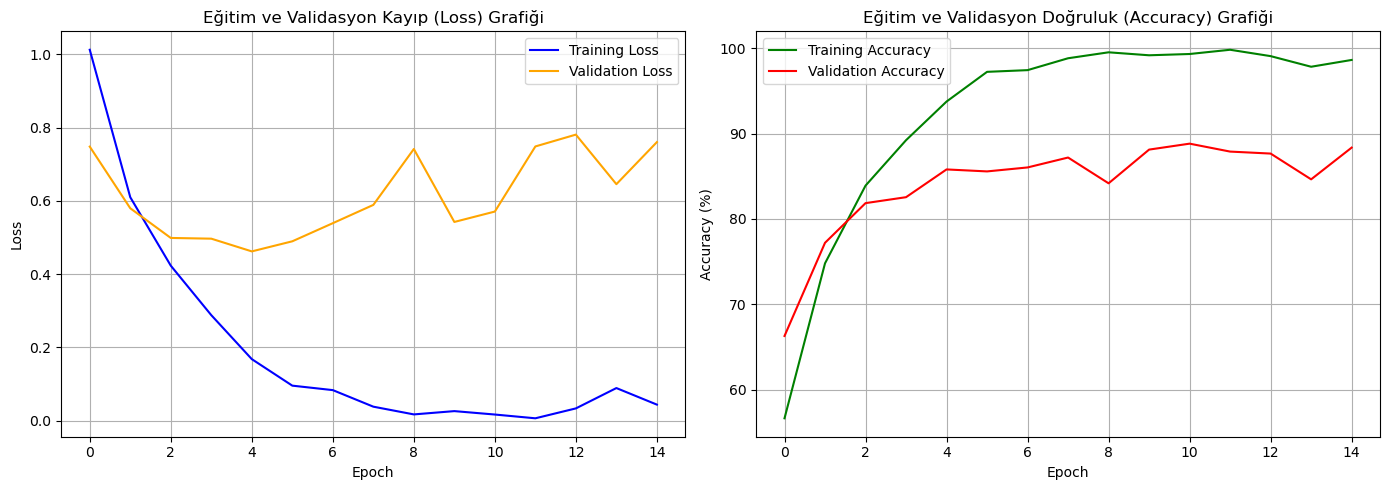

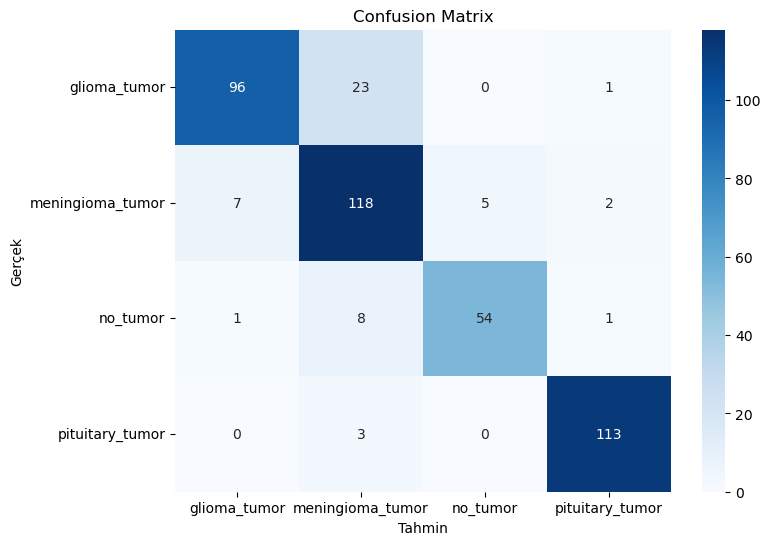


--- SINIFLANDIRMA RAPORU ---

                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.80      0.86       120
meningioma_tumor       0.78      0.89      0.83       132
        no_tumor       0.92      0.84      0.88        64
 pituitary_tumor       0.97      0.97      0.97       116

        accuracy                           0.88       432
       macro avg       0.90      0.88      0.88       432
    weighted avg       0.89      0.88      0.88       432



In [8]:
# Grafik Çizimi (Loss ve Accuracy Yan Yana)
plt.figure(figsize=(14, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Eğitim ve Validasyon Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Eğitim ve Validasyon Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TEST VE CONFUSION MATRIX
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

classes = full_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

print("\n--- SINIFLANDIRMA RAPORU ---\n")
print(classification_report(all_labels, all_preds, target_names=classes))